In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 14.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from prophet import Prophet
import optuna
import shap
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MultiLabelBinarizer as MLB
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
file_path = "/content/paris_temperature.csv"
df = pd.read_csv(file_path)
df.sample(5)

name    datetime  tempmax  tempmin  temp  feelslikemax  \
209  Paris,France  2024-04-27     16.0      9.7  12.3          16.0   
23   Paris,France  2023-10-24     16.3     11.1  12.9          16.3   
316  Paris,France  2024-08-12     36.2     20.7  28.3          36.6   
349  Paris,France  2024-09-14     17.2      8.4  12.8          17.2   
214  Paris,France  2024-05-02     13.7     10.7  11.6          13.7   

     feelslikemin  feelslike   dew  humidity  ...  solarenergy  uvindex  \
209           8.5       12.1  10.1      87.2  ...          5.2        4   
23           11.1       12.9  10.0      83.8  ...          2.8        4   
316          20.7       28.5  17.2      54.6  ...          6.9        6   
349           7.7       12.7   6.9      69.4  ...          3.8        3   
214          10.7       11.6   9.6      87.5  ...          2.9        1   

     severerisk              sunrise               sunset  moonphase  \
209          10  2024-04-27T06:36:32  2024-04-27T21:00:57       0.62   
23           10  2023-10-24T08:24:17  2023-10-24T18:44:43       0.34   
316          30  2024-08-12T06:39:37  2024-08-12T21:10:45       0.25   
349          10  2024-09-14T07:26:17  2024-09-14T20:05:00       0.38   
214          10  2024-05-02T06:27:56  2024-05-02T21:08:16       0.80   

                 conditions  \
209          Rain, Overcast   
23   Rain, Partially cloudy   
316                   Clear   
349  Rain, Partially cloudy   
214          Rain, Overcast   

                                           description       icon  \
209  Cloudy skies throughout the day with a chance ...       rain   
23   Partly cloudy throughout the day with rain cle...       rain   
316               Clear conditions throughout the day.  clear-day   
349  Partly cloudy throughout the day with early mo...       rain   
214         Cloudy skies throughout the day with rain.       rain   

                                              stations  
209  07149099999,07156099999,07146099999,0714509999...  
23   07149099999,07156099999,07146099999,0715709999...  
316                   LFPV,C1292,LFPO,07147099999,LFPB  
349  07149099999,07156099999,07146099999,0715709999...  
214  07149099999,07156099999,07146099999,0715709999...  

[5 rows x 33 columns]

In [ ]:
df.columns

Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')

In [ ]:
# 1. Tiền xử lý dữ liệu
df['datetime'] = pd.to_datetime(df['datetime'])
df.sort_values(by="datetime", inplace=True)
df['sunrise'] = pd.to_datetime(df['sunrise'])
df['sunset'] = pd.to_datetime(df['sunset'])

df = df.drop(['name','description','icon'], axis = 1)
# df.set_index("datetime", inplace=True)

# # Kiểm tra ngoại lệ bằng boxplot
# plt.figure(figsize=(10, 5))
# sns.boxplot(x=df['temp'])
# plt.title("Boxplot of Temperature")
# plt.show()

# # Loại bỏ ngoại lệ bằng IQR
# Q1 = df['temp'].quantile(0.25)
# Q3 = df['temp'].quantile(0.75)
# IQR = Q3 - Q1
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR
# df = df[(df['temp'] >= lower_bound) & (df['temp'] <= upper_bound)]

In [ ]:
# 2. Khám phá các đặc trưng
print(df.info())
# print(df.describe())
# print(df.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382 entries, 0 to 381
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          382 non-null    datetime64[ns]
 1   tempmax           382 non-null    float64       
 2   tempmin           382 non-null    float64       
 3   temp              382 non-null    float64       
 4   feelslikemax      382 non-null    float64       
 5   feelslikemin      382 non-null    float64       
 6   feelslike         382 non-null    float64       
 7   dew               382 non-null    float64       
 8   humidity          382 non-null    float64       
 9   precip            382 non-null    float64       
 10  precipprob        382 non-null    float64       
 11  precipcover       382 non-null    float64       
 12  preciptype        308 non-null    object        
 13  snow              382 non-null    float64       
 14  snowdepth         382 non-

In [ ]:
df.isnull().sum()

datetime             0
tempmax              0
tempmin              0
temp                 0
feelslikemax         0
feelslikemin         0
feelslike            0
dew                  0
humidity             0
precip               0
precipprob           0
precipcover          0
preciptype          74
snow                 0
snowdepth            0
windgust             0
windspeed            0
winddir              0
sealevelpressure     0
cloudcover           0
visibility           0
solarradiation       0
solarenergy          0
uvindex              0
severerisk           0
sunrise              0
sunset               0
moonphase            0
conditions           0
stations            14
dtype: int64

In [ ]:
df['temp'].min()

-1.8

# Column meaning
>**'name'**: City where the weather data is recorded (Paris, France)
>> Value: Paris, France
>
>**'datetime'**: Date of observation
>> Value: 2023-10-16
>
>**'tempmax'**: Highest recorded temperature of the day
>> Value: From -1.3 to 36.2
>
>**'tempmin'**: Lowest recorded temperature of the day
>> Value: From -4.1 to 21.2
>
>**'temp'**: Temperature of the day
>> Value: From -1.8 to 28.3
>
>**'feelslikemax'**: Highest "feel-like" temperature when considering wind and humidity
>> Value: From -5.5 to 39
>
>**'feelslikemin'**: Lowest "feel-like" temperature when considering wind and humidity
>> Value: From -7.3 to 21.2
>
>**'feelslike'**: Overall "feel-like" temperature for the day
>> Value: From -6.3 to 29.6
>
>**'dew'**: Temperature at which air becomes saturated, leading to dew, fog or precipitation
>> Value: From -6.1 to 20.3
>
>**'humidity'**: Air humidity as a percentage of its maximum water vapor capacity
>> Value: From 51.6 to 95
>
>**'precip'**: Total daily rainfall(mm)
>> Value: From 0 to 25
>
>**'precipprob'**: Probability of rainfall in a day
>> Value: From 0 to 100
>
>**'precipcover'**: Percentage of the day with rainfall
>> Value: From 0 to 75
>
>**'preciptype'**: Type of precipitation
>> Value: 'rain', nan, 'rain,snow', 'rain,freezingrain,snow'
>
>**'snow'**: Total daily snowfall(cm or inches)
>> Value: From 0 to 5.4
>
>**'snowdepth'**: Average snow depth on the ground
>> Value: From 0 to 3.9
>
>**'windgust'**: Highest wind speed recorded in short bursts
>> Value: From 14.4 to 92.2
>
>**'windspeed'**: Average wind speed
>> Value: From 6.7 to 44.3
>
>**'winddir'**: Wind direction in degrees from North
>> Value: From 0.4 to 358.2
>
>**'sealevelpressure'**: Atmospheric pressure adjusted to sea level
>> Value: From 979.7 to 1042.8
>
>**'cloudcover'**: Percentage of sky covered bu clouds
>> Value: From 13 to 100
>
>**'visibility'**: Maximum distance one can see clearly
>> Value: From 5.1 to 39.1
>
>**'solarradiation'**: Solar intensity at Earth"s surface
>> Value: From 0 to 169.8
>
>**'solarenergy'**: Total solar energy received in a day
>> value: From 0 to 14.7
>
>**'uvindex'**: UV exposure level(0-10 scale)
>> Value: From 0 to 8
>
>**'severerisk'**: Probability of extreme weather conditions
>> Value: From 10 to 75
>
>**'sunrise'**: Local time of sunrise
>> Value: 2023-10-01T07:49:34
>
>**'sunset'**: Local time of sunset
>> Value: 2023-10-01T19:30:27
>
>**'moonphase'**: Decimal value (0-1) representing the moon cycle
>> Value: From 0 to 1, 0.5 is already full moon
>
>**'conditions'**: Key weather highlights of the day
>> Value: 'Rain, Partially cloudy' for instance
>
>**'description'**: Short summary of the day's weather
>> Value: 'Becoming cloudy in the afternoon with morning rain.' for instance
>
>**'icon'**: Name of the weather icon used for the day
>> Value: 'rain', 'partly-cloudy-day', 'clear-day', 'cloudy', 'snow'
>
>**'stations'**: ID or location of the weather station collecting data
>> Value: '07149099999,07156099999,07146099999,07157099999,C1292,07147099999,07150099999' for instance

In [ ]:
# 3. Phân loại đặc trưng
df_numeric = df.select_dtypes(include=[np.number]).columns
df_datetime = df.select_dtypes(include=[np.datetime64]).columns
df_categorical = df.select_dtypes(include=[object]).columns
print(f"Numerical Features: {list(df_numeric)}")
print(f"Categorical Features: {list(df_categorical)}")
print(f"DateTime Features: {list(df_datetime)}")

Numerical Features: ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'moonphase']
Categorical Features: ['preciptype', 'conditions', 'stations']
DateTime Features: ['datetime', 'sunrise', 'sunset']


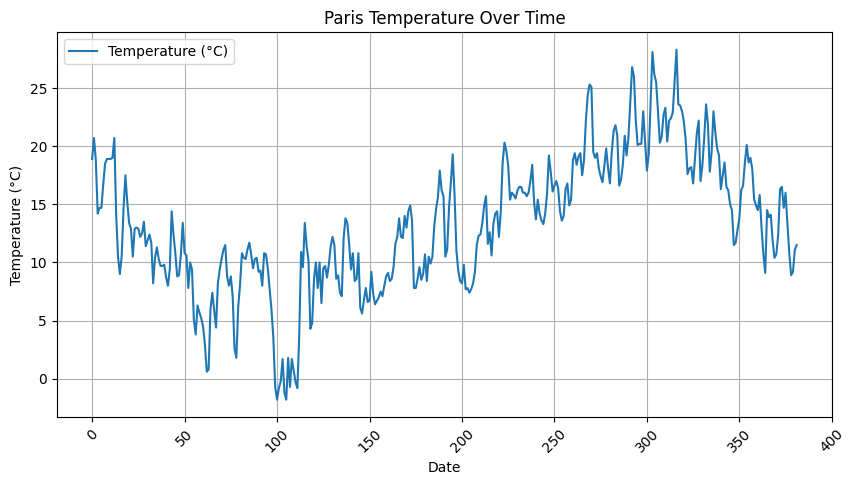

In [ ]:

# plt.figure(figsize=(12, 5))
# plt.plot(df["temp"], label="Paris Temperature")
# plt.legend()
# plt.title("Paris Temperature Over Time")
# plt.show()
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['temp'], linestyle='-', label='Temperature (°C)')
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Paris Temperature Over Time")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()

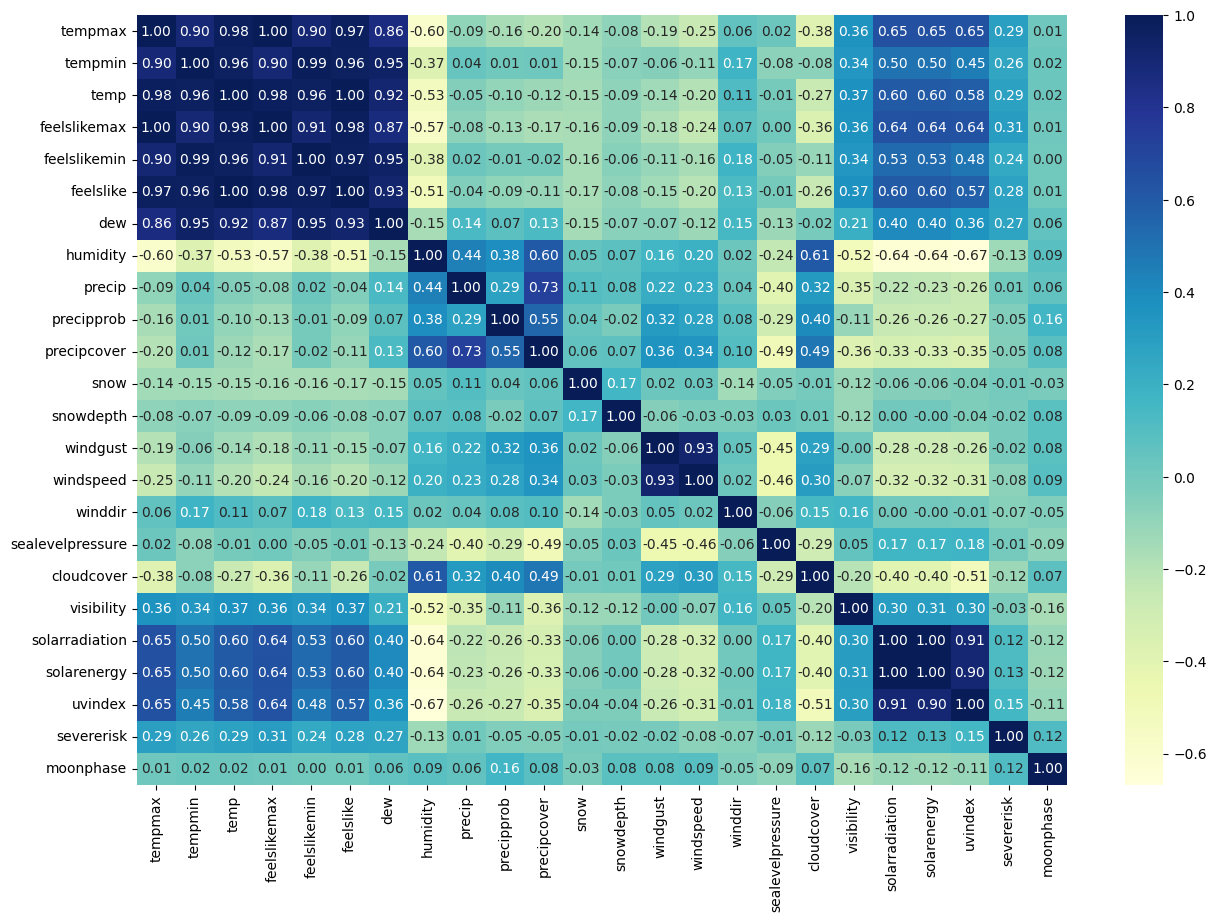

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(df[df_numeric].corr(), cmap='YlGnBu', annot=True, fmt=".2f")
plt.show()


### Check Stationary

In [ ]:

# Perform Augmented Dickey-Fuller (ADF) test on 'temp' column
adf_result = adfuller(df['temp'])

# Output the results
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')

if adf_result[1] < 0.05:
    print("df_paris_temperature is stationary (reject null hypothesis/no unit root).")
else:
    print("df_paris_temperature is non-stationary (fail to reject null hypothesis/unit root).")

ADF Statistic: -2.742622887630039
p-value: 0.06694856335880962
Critical Values:
	1%: -3.4477686860685
	5%: -2.869216670067509
	10%: -2.570859500573892
df_paris_temperature is non-stationary (fail to reject null hypothesis/unit root).


Since the ADF Statistic (-2.7426) is not smaller than the critical value at the 5% level (-2.8692) and the p-value is greater than 0.05, we cannot reject the null hypothesis (H₀).

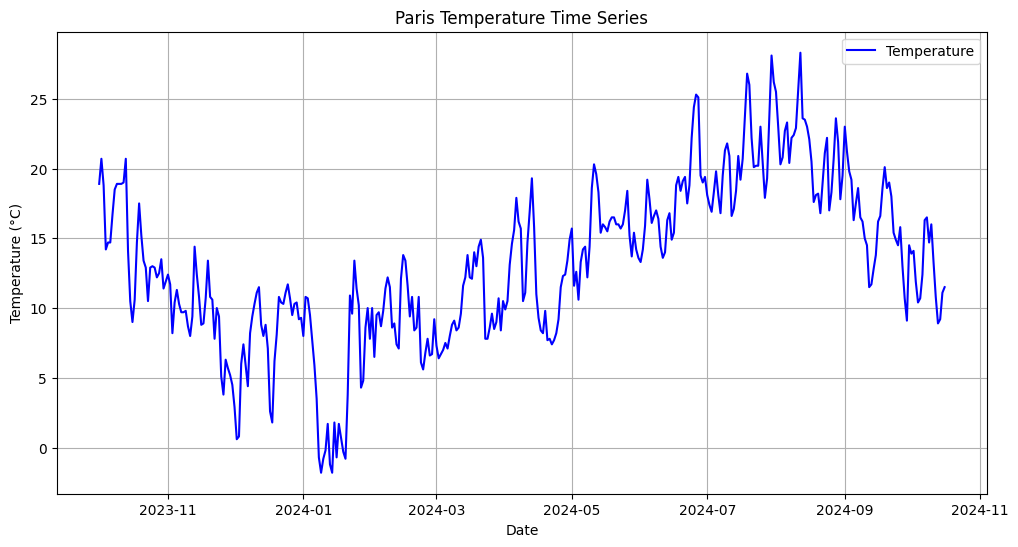

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df["datetime"], df["temp"], label="Temperature", color="b")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Paris Temperature Time Series")
plt.legend()
plt.grid(True)
plt.show()


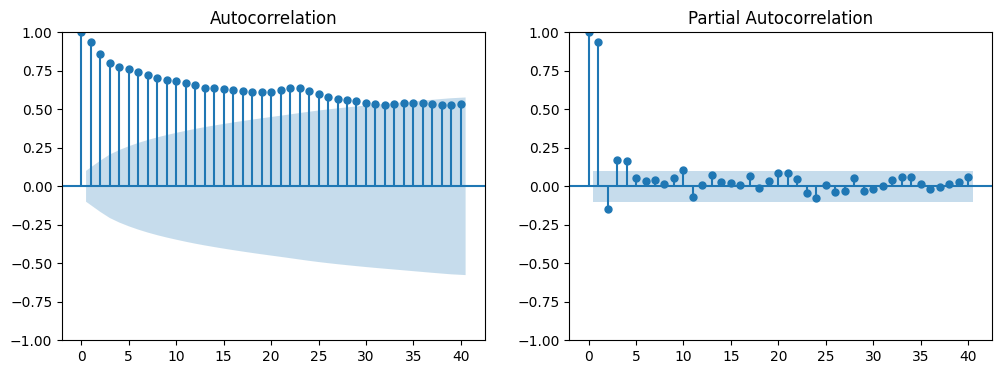

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(df['temp'], ax=ax[0], lags=40)
plot_pacf(df['temp'], ax=ax[1], lags=40)
plt.show()


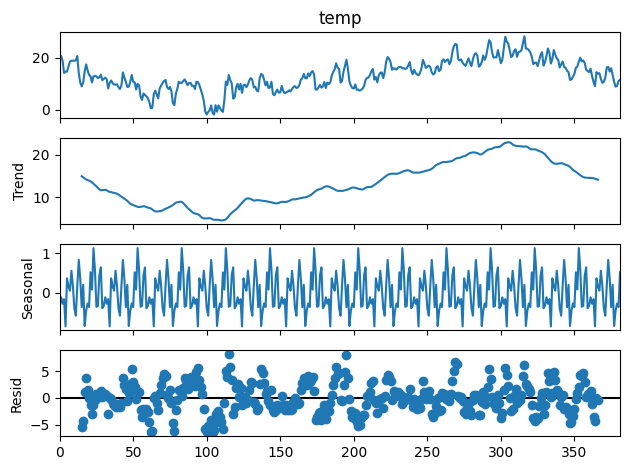

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the price time series over n days
res_price = seasonal_decompose(df['temp'], model='additive', period=30)

# Plot the decomposition results
res_price.plot()
plt.show()

###Differencing

In [ ]:
adf_result = adfuller(df["temp"].diff(1).dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"\t{key}: {value}")
if adf_result[1] < 0.05:
    print("The series is stationary (reject null hypothesis/no unit root).")
else:
    print("The series is non-stationary (fail to reject null hypothesis/unit root).")


ADF Statistic: -14.794239815296418
p-value: 2.1478107704102706e-27
Critical Values:
	1%: -3.4477686860685
	5%: -2.869216670067509
	10%: -2.570859500573892
The series is stationary (reject null hypothesis/no unit root).


Since p-value < 0.05, we reject the null hypothesis H0
 , meaning the series is stationary (no unit root).

✅ Only one differencing step was needed to achieve stationarity.

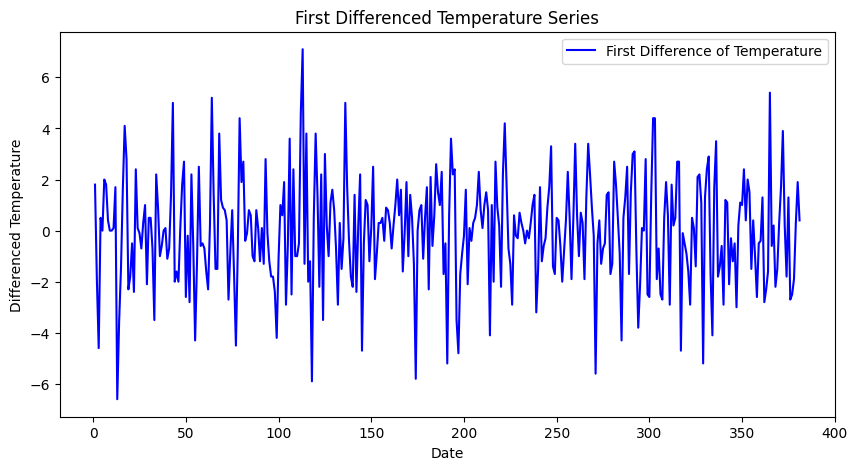

In [ ]:
# Plot First Differenced Series
plt.figure(figsize=(10,5))
plt.plot(df["temp"].diff(1), label="First Difference of Temperature", color='blue')
plt.xlabel("Date")
plt.ylabel("Differenced Temperature")
plt.title("First Differenced Temperature Series")
plt.legend()
plt.show()

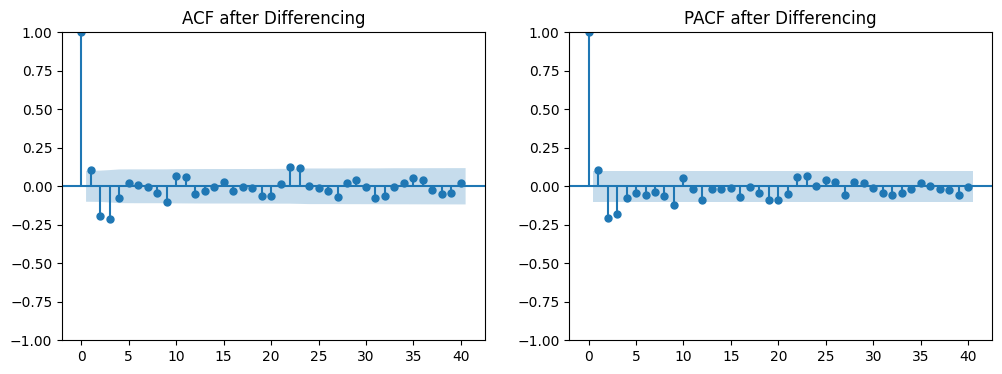

In [ ]:
# Vẽ ACF & PACF sau khi lấy sai phân bậc 1
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df['temp'].diff().dropna(), ax=ax[0], lags=40)
plot_pacf(df['temp'].diff().dropna(), ax=ax[1], lags=40)

ax[0].set_title("ACF after Differencing")
ax[1].set_title("PACF after Differencing")

plt.show()


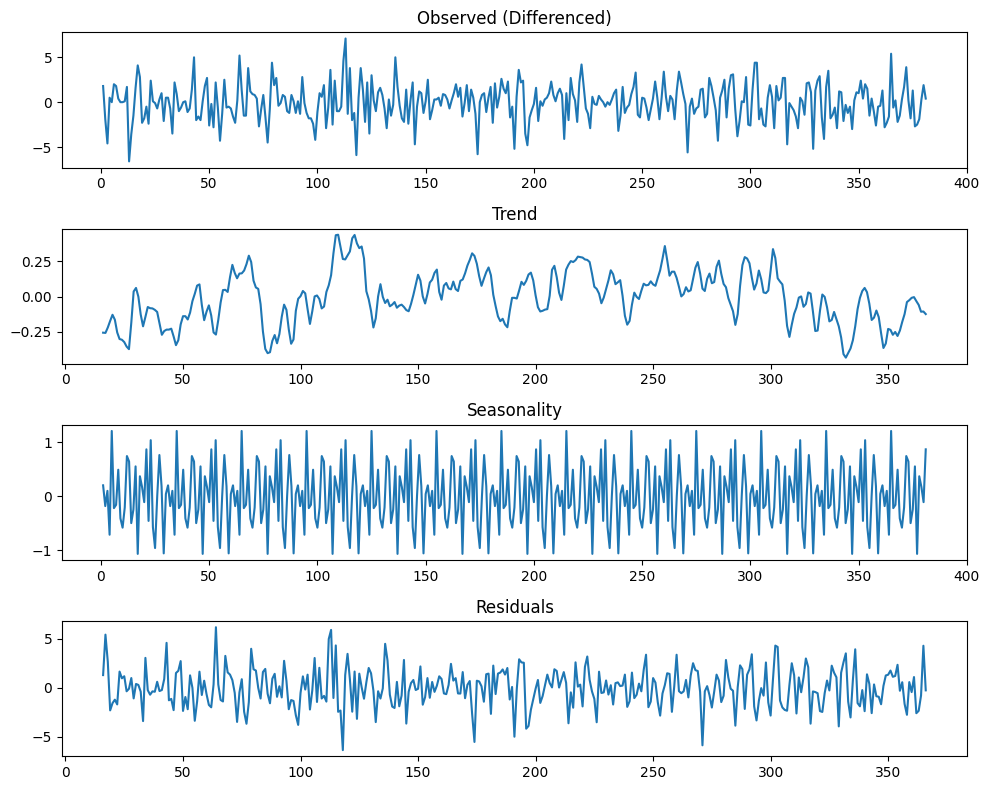

In [ ]:
#Perform decomposition on the differenced series
temp_diff = df['temp'].diff().dropna()

res_price = seasonal_decompose(temp_diff, model='additive', period=30)

fig, axes = plt.subplots(4, 1, figsize=(10, 8))
res_price.observed.plot(ax=axes[0], title="Observed (Differenced)")
res_price.trend.plot(ax=axes[1], title="Trend")
res_price.seasonal.plot(ax=axes[2], title="Seasonality")
res_price.resid.plot(ax=axes[3], title="Residuals")

plt.tight_layout()
plt.show()

### Cleaning data

In [ ]:
df['preciptype'] = df['preciptype'].fillna('nope')
mode_station = df['stations'].mode()[0]
df['stations'] = df['stations'].fillna(mode_station)


### Prophet Model

In [ ]:
# 5. Chia tập dữ liệu
train = df[(df['datetime'] >= '2023-10-01') & (df['datetime'] <= '2024-09-15')]
test = df[df['datetime'] > '2024-09-15']
train.shape, test.shape

((351, 30), (31, 30))

In [ ]:
train_datetime = train[df_datetime].copy()
test_datetime = test[df_datetime].copy()

In [ ]:
train_prophet = train.rename(columns={"datetime": "ds", "temp": "y"})
test_prophet = test.rename(columns={"datetime": "ds", "temp": "y"})
# Khởi tạo mô hình Prophet
model = Prophet()

# Huấn luyện mô hình chỉ với `ds` và `y`
model.fit(train_prophet)
# Tạo tập dữ liệu dự báo
future = model.make_future_dataframe(periods=len(test_prophet), freq='D')
forecast = model.predict(future)

# Lọc dự báo chỉ cho khoảng thời gian của tập test
forecast_test = forecast[forecast["ds"].isin(test_prophet["ds"])]
# Tính toán lỗi
rmse_prophet = np.sqrt(mean_squared_error(test_prophet["y"], forecast_test["yhat"]))
r2_prophet = r2_score(test_prophet["y"], forecast_test["yhat"])

# Hàm tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_prophet = mean_absolute_percentage_error(test_prophet["y"], forecast_test["yhat"])

# In kết quả
print(f"RMSE Prophet: {rmse_prophet:.2f}")
print(f"R² Prophet: {r2_prophet:.4f}")
print(f"MAPE Prophet: {mape_prophet:.2f}%")


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdvfjju77/j2dw1i0j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdvfjju77/9n791694.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2556', 'data', 'file=/tmp/tmpdvfjju77/j2dw1i0j.json', 'init=/tmp/tmpdvfjju77/9n791694.json', 'output', 'file=/tmp/tmpdvfjju77/prophet_modelgxnoaxur/prophet_model-20250330150815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:08:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:08:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE Prophet: 9.18
R² Prophet: -7.8401
MAPE Prophet: 69.52%


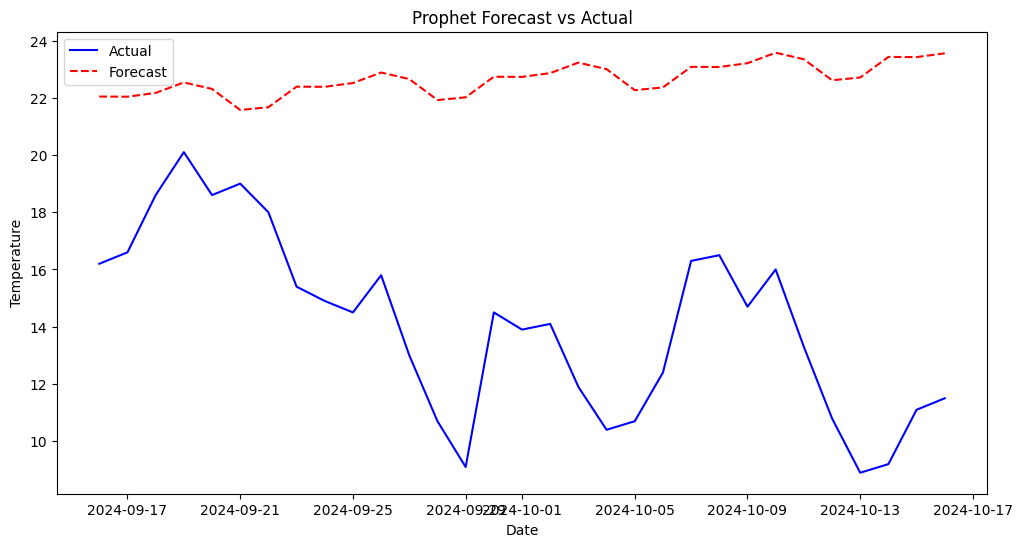

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(test_prophet["ds"], test_prophet["y"], label="Actual", color="blue")
plt.plot(forecast_test["ds"], forecast_test["yhat"], label="Forecast", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Prophet Forecast vs Actual")
plt.legend()
plt.show()

In [ ]:
# Adding exogenous variables: Some features have a high correlation with the target column ('temp').
df_prophet = df[['datetime', 'temp', 'feelslike', 'solarradiation', 'solarenergy', 'uvindex','humidity']].copy()
df_prophet.rename(columns={'datetime': 'ds', 'temp': 'y'}, inplace=True)

train_prophet = df_prophet[(df_prophet['ds'] >= '2023-10-01') & (df_prophet['ds'] <= '2024-09-15')].copy()
test_prophet = df_prophet[df_prophet['ds'] > '2024-09-15'].copy()

print(f" Train shape: {train_prophet.shape}, Test shape: {test_prophet.shape}")

model = Prophet()
regressors = [ 'feelslike', 'solarradiation', 'solarenergy', 'uvindex','humidity']
for reg in regressors:
    model.add_regressor(reg)
model.fit(train_prophet)

future = test_prophet[['ds', 'feelslike', 'solarradiation', 'solarenergy', 'uvindex','humidity']].copy()
forecast = model.predict(future)


forecast_test = forecast[['ds', 'yhat']]
results = test_prophet[['ds', 'y']].merge(forecast_test, on='ds', how='left')


rmse_prophet = np.sqrt(mean_squared_error(results["y"], results["yhat"]))
r2_prophet = r2_score(results["y"], results["yhat"])

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_prophet = mean_absolute_percentage_error(results["y"], results["yhat"])

print(f"📌 RMSE Prophet: {rmse_prophet:.2f}")
print(f"📌 R² Score Prophet: {r2_prophet:.4f}")
print(f"📌 MAPE Prophet: {mape_prophet:.2f}%")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdvfjju77/nkwmmm8w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdvfjju77/ddahcrc5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21641', 'data', 'file=/tmp/tmpdvfjju77/nkwmmm8w.json', 'init=/tmp/tmpdvfjju77/ddahcrc5.json', 'output', 'file=/tmp/tmpdvfjju77/prophet_model8tyhruif/prophet_model-20250330150816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:08:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:08:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Train shape: (351, 7), Test shape: (31, 7)
📌 RMSE Prophet: 0.64
📌 R² Score Prophet: 0.9564
📌 MAPE Prophet: 4.36%


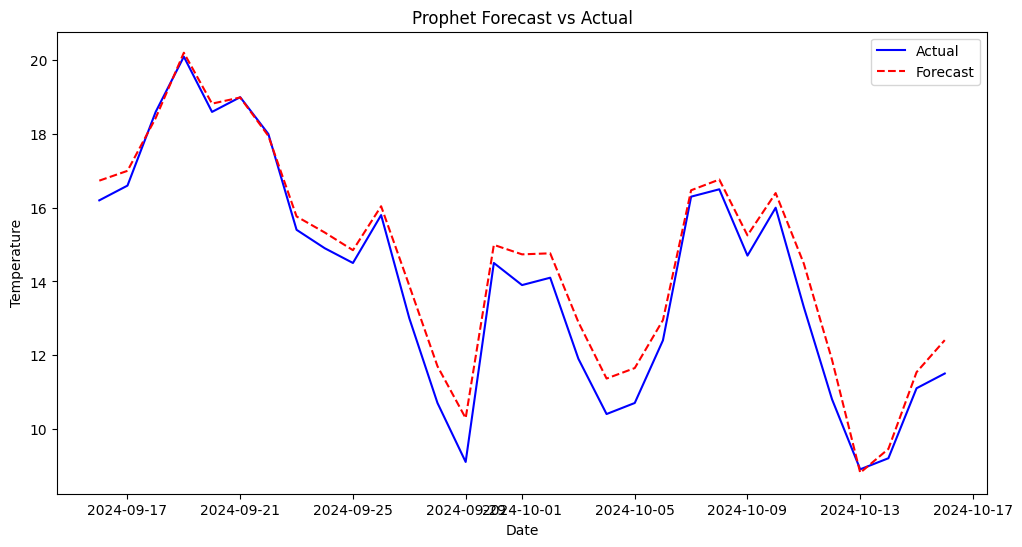

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(test_prophet["ds"], test_prophet["y"], label="Actual", color="blue")
plt.plot(forecast_test["ds"], forecast_test["yhat"], label="Forecast", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Prophet Forecast vs Actual")
plt.legend()
plt.show()


Prophet originally relied only on time (ds) for forecasting, but temperature is influenced by many other factors such as humidity, solar radiation, etc. So the model performed very poorly.

By adding exogenous variables like feelslike, humidity, solarradiation,... Prophet learns the relationship between temperature and real-world weather factors, making forecasts much more accurate.

# Feature Engineering


In [ ]:
# 6. Feature Engineering
for dataset in [train, test]:
    dataset['year'] = dataset['datetime'].dt.year
    dataset['month'] = dataset['datetime'].dt.month
    dataset['day'] = dataset['datetime'].dt.day
    dataset['dayofweek'] = dataset['datetime'].dt.dayofweek
    dataset['season'] = dataset['month'] % 12 // 3 + 1  # 1: Winter, 2: Spring, 3: Summer, 4: Fall
    dataset['sunrise_hour'] = dataset['sunrise'].dt.hour
    dataset['sunrise_minute'] = dataset['sunrise'].dt.minute
    dataset['sunset_hour'] = dataset['sunset'].dt.hour
    dataset['sunset_minute'] = dataset['sunset'].dt.minute

    dataset['daylight_duration'] = (dataset['sunset_hour'] * 60 + dataset['sunset_minute']) - \
                                (dataset['sunrise_hour'] * 60 + dataset['sunrise_minute'])
    dataset['temp_lag_1'] = dataset['temp'].shift(1)  # Nhiệt độ ngày trước đó
    dataset['temp_lag_7'] = dataset['temp'].shift(7)  # Nhiệt độ cùng ngày tuần trước
    dataset['temp_roll_7'] = dataset['temp'].rolling(window=7, min_periods=1).mean()
    dataset['temp_roll_30'] = dataset['temp'].rolling(window=30, min_periods=1).mean()

    for col in df_numeric:
        dataset[f"{col}_7d_avg"] = dataset[col].rolling(window=7).mean()


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_scaled = pd.DataFrame(scaler.fit_transform(train[df_numeric]), columns=df_numeric, index=train.index)
test_scaled = pd.DataFrame(scaler.transform(test[df_numeric]), columns=df_numeric, index=test.index)

# One-Hot Encoding cho cột phân loại
mlb_col = ['conditions','stations']
df_categorical = df_categorical.drop(mlb_col)
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False,drop='first',handle_unknown='ignore')
train_encoded = pd.DataFrame(
    encoder.fit_transform(train[df_categorical]),
    index=train.index
)
test_encoded = pd.DataFrame(
    encoder.transform(test[df_categorical]),
    index=test.index
)

train_encoded.columns = encoder.get_feature_names_out(df_categorical)
test_encoded.columns = encoder.get_feature_names_out(df_categorical)


train['conditions_list'] = train['conditions'].apply(lambda x: [cond.strip() for cond in x.split(',')] if isinstance(x, str) else [])
test['conditions_list'] = test['conditions'].apply(lambda x: [cond.strip() for cond in x.split(',')] if isinstance(x, str) else [])
train['stations_list'] = train['stations'].apply(lambda x: [s.strip() for s in x.split(',')] if isinstance(x, str) else [])
test['stations_list'] = test['stations'].apply(lambda x: [s.strip() for s in x.split(',')] if isinstance(x, str) else [])

mlb = MLB()
# Mã hóa conditions
conditions_encoded_train = mlb.fit_transform(train['conditions_list'])
conditions_encoded_test = mlb.transform(test['conditions_list'])
df_conditions = pd.DataFrame(conditions_encoded_train, columns=[f'condition_{c}' for c in mlb.classes_], index=train.index)
df_conditions_test = pd.DataFrame(conditions_encoded_test, columns=[f'condition_{c}' for c in mlb.classes_], index=test.index)

# Mã hóa stations
stations_encoded_train = mlb.fit_transform(train['stations_list'])
stations_encoded_test = mlb.transform(test['stations_list'])
df_stations = pd.DataFrame(stations_encoded_train, columns=[f'station_{s}' for s in mlb.classes_], index=train.index)
df_stations_test = pd.DataFrame(stations_encoded_test, columns=[f'station_{s}' for s in mlb.classes_], index=test.index)

# train_conditions_encoded = pd.DataFrame(mlb.fit_transform(train['conditions_list']),
#                                         columns=mlb.classes_, index=train.index)
# test_conditions_encoded = pd.DataFrame(mlb.transform(test['conditions_list']),
#                                        columns=mlb.classes_, index=test.index)
# # Fix: Combine data properly while keeping indices aligned
# Gộp tất cả các phần đã xử lý vào dataset

train_processed = pd.concat([train_scaled, train_encoded, df_conditions, df_stations, train_datetime], axis=1)
test_processed = pd.concat([test_scaled, test_encoded, df_conditions_test, df_stations_test, test_datetime], axis=1)




In [ ]:
X_train = train_processed.drop(columns=['datetime','sunrise', 'sunset', 'temp'])
X_train.columns = X_train.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
y_train = train_processed['temp']
X_test = test_processed.drop(columns=['datetime','sunrise', 'sunset', 'temp'])
X_test.columns = X_test.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
y_test = test_processed['temp']

In [ ]:
X_train.head(2)

tempmax   tempmin  feelslikemax  feelslikemin  feelslike       dew  \
0  1.383420  0.489671      1.316252      0.585716   0.929836  1.039523   
1  1.553853  0.876385      1.500134      0.901492   1.191865  1.245305   

   humidity    precip  precipprob  precipcover  ...  station_07149099999  \
0 -0.149378 -0.475312    0.604780    -0.673078  ...                    1   
1 -0.471046 -0.512395   -1.653494    -0.917902  ...                    1   

   station_07150099999  station_07153099999  station_07156099999  \
0                    1                    0                    1   
1                    1                    0                    1   

   station_07157099999  station_C1292  station_D3623  station_LFPB  \
0                    1              1              0             0   
1                    1              1              0             0   

   station_LFPO  station_LFPV  
0             0             0  
1             0             0  

[2 rows x 45 columns]

In [ ]:
# Tìm các cột có giá trị NaN trong X_train
missing_cols = X_train.columns[X_train.isna().any()]
print("Các cột có NaN:", missing_cols)

# Áp dụng nội suy tuyến tính và điền bằng giá trị trung bình cho các cột có NaN
X_train[missing_cols] = X_train[missing_cols].apply(
    lambda col: col.interpolate(method='linear').fillna(col.mean())
)


Các cột có NaN: Index([], dtype='object')


#### LGBM

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

def objective(trial):
    # Gợi ý các siêu tham số cho mô hình
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000)
    }

    # Khởi tạo mô hình LightGBM với các tham số được gợi ý
    model = lgb.LGBMRegressor(**params,random_state=42)

    # Sử dụng TimeSeriesSplit cho CV trong dữ liệu time series
    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []  # Danh sách lưu RMSE cho mỗi split

    for train_index, val_index in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        # Tính RMSE cho lần chia này
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    # Trả về trung bình RMSE qua các split
    return np.mean(rmse_scores)


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
best_params = study.best_params
lgbm_model = lgb.LGBMRegressor(**best_params, random_state=42)
lgbm_model.fit(X_train, y_train)
lgbm_pred = lgbm_model.predict(X_test)


[I 2025-03-30 15:08:29,470] A new study created in memory with name: no-name-89933d13-694e-4ee9-9644-151ec6a24592


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 379
[LightGBM] [Info] Number of data points in the train set: 61, number of used features: 21
[LightGBM] [Info] Start training from score -0.178448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-03-30 15:08:30,705] Trial 0 finished with value: 0.3500346655567732 and parameters: {'num_leaves': 295, 'learning_rate': 0.08897758384646072, 'n_estimators': 860}. Best is trial 0 with value: 0.3500346655567732.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 379
[LightGBM] [Info] Number of data points in the train set: 61, number of used features: 21
[LightGBM] [Info] Start training from score -0.178448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-03-30 15:08:30,953] Trial 1 finished with value: 0.35275567373407546 and parameters: {'num_leaves': 156, 'learning_rate': 0.15776729375229087, 'n_estimators': 176}. Best is trial 0 with value: 0.3500346655567732.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1174
[LightGBM] [Info] Number of data points in the train set: 235, number of used features: 29
[LightGBM] [Info] Start training from score -0.493411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-03-30 15:08:31,430] Trial 2 finished with value: 0.3513920862485422 and parameters: {'num_leaves': 98, 'learning_rate': 0.09563105660979515, 'n_estimators': 403}. Best is trial 0 with value: 0.3500346655567732.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1415
[LightGBM] [Info] Number of data points in the train set: 293, number of used features: 29
[LightGBM] [Info] Start training from score -0.234088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-03-30 15:08:31,670] Trial 3 finished with value: 0.3504943371209145 and parameters: {'num_leaves': 152, 'learning_rate': 0.27634808433439567, 'n_estimators': 175}. Best is trial 0 with value: 0.3500346655567732.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 928
[LightGBM] [Info] Number of data points in the train set: 177, number of used features: 25
[LightGBM] [Info] Start training from score -0.646921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-03-30 15:08:32,432] Trial 4 finished with value: 0.3512980598621603 and parameters: {'num_leaves': 133, 'learning_rate': 0.09460400853420223, 'n_estimators': 633}. Best is trial 0 with value: 0.3500346655567732.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-30 15:08:33,233] Trial 5 finished with value: 0.3529868485122354 and parameters: {'num_leaves': 280, 'learning_rate': 0.16183562294292284, 'n_estimators': 624}. Best is trial 0 with value: 0.3500346655567732.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-30 15:08:34,199] Trial 6 finished with value: 0.34907214825388516 and parameters: {'num_leaves': 230, 'learning_rate': 0.28592624046210746, 'n_estimators': 787}. Best is trial 6 with value: 0.34907214825388516.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-30 15:08:35,472] Trial 7 finished with value: 0.35053893573135875 and parameters: {'num_leaves': 144, 'learning_rate': 0.08814793240007282, 'n_estimators': 992}. Best is trial 6 with value: 0.34907214825388516.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-30 15:08:35,810] Trial 8 finished with value: 0.34791159187372195 and parameters: {'num_leaves': 145, 'learning_rate': 0.08645843086711634, 'n_estimators': 230}. Best is trial 8 with value: 0.34791159187372195.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-30 15:08:36,091] Trial 9 finished with value: 0.3472021611195407 and parameters: {'num_leaves': 246, 'learning_rate': 0.0450492696446297, 'n_estimators': 192}. Best is trial 9 with value: 0.3472021611195407.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1174
[LightGBM] [Info] Number of data points in the train set: 235, number of used features: 29
[LightGBM] [Info] Start training from score -0.493411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [ ]:
rmse_lgbm = np.sqrt(mean_squared_error(y_test, lgbm_pred))
r2_lgbm = r2_score(y_test, lgbm_pred)
mape_lgbm = mean_absolute_percentage_error(y_test, lgbm_pred)

print(f"🔥 RMSE LGBM: {rmse_lgbm}")
print(f"🔥 R² Score LGBM: {r2_lgbm}")
print(f"🔥 MAPE LGBM: {mape_lgbm}")

🔥 RMSE LGBM: 0.03123175423780784
🔥 R² Score LGBM: 0.9963317191604734
🔥 MAPE LGBM: 16.050011249853497


#### Random forrest

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import optuna

def objective(trial):
    # Gợi ý các siêu tham số cho RandomForestRegressor
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }

    # Khởi tạo mô hình Random Forest với các tham số được gợi ý
    model = RandomForestRegressor(**params, random_state=42)

    # Sử dụng TimeSeriesSplit cho cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []  # Lưu RMSE cho từng split

    for train_index, val_index in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        # Tính RMSE cho lần chia này
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    # Trả về trung bình RMSE qua các split
    return np.mean(rmse_scores)

# Tạo study và tối ưu hóa objective


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
best_params = study.best_params

# Huấn luyện mô hình Random Forest với tham số tốt nhất trên toàn bộ tập huấn luyện
rf_model = RandomForestRegressor(**best_params, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Tính các metric đánh giá
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_pred))
r2_rf = r2_score(y_test, rf_pred)
mape_rf = mean_absolute_percentage_error(y_test, rf_pred)

print(f"🔥 RMSE RF: {rmse_rf}")
print(f"🔥 R² Score RF: {r2_rf}")
print(f"🔥 MAPE RF: {mape_rf}")


[I 2025-03-30 15:08:36,292] A new study created in memory with name: no-name-b96b7269-5e95-4595-bc6d-62e0ac7bd568
[I 2025-03-30 15:08:48,574] Trial 0 finished with value: 0.20787650375880337 and parameters: {'n_estimators': 775, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 0 with value: 0.20787650375880337.
[I 2025-03-30 15:08:55,964] Trial 1 finished with value: 0.44721656316438274 and parameters: {'n_estimators': 848, 'max_depth': 16, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.20787650375880337.
[I 2025-03-30 15:09:02,454] Trial 2 finished with value: 0.33517748892683874 and parameters: {'n_estimators': 543, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 0 with value: 0.20787650375880337.
[I 2025-03-30 15:09:13,279] Trial 3 finished with value: 0.2825704380012011 and parameters: {'n_estimators': 554, 'max_depth': 13

🔥 RMSE RF: 0.025136458822735363
🔥 R² Score RF: 0.9976238272535831
🔥 MAPE RF: 0.074704872048058


### Giải thích tham số
Kiểm soát overfitting: Các tham số như num_leaves (cho LightGBM) hoặc max_depth, min_samples_split, min_samples_leaf (cho Random Forest) được điều chỉnh để tìm được sự cân bằng giữa khả năng học chi tiết và khả năng khái quát hóa.

Hiệu quả tính toán: Số lượng cây (n_estimators) và learning_rate được giới hạn trong khoảng hợp lý để đảm bảo mô hình không quá chậm nhưng vẫn đạt hiệu năng cao.

In [ ]:
data = {'Model': ['Prophet', 'RF', 'LGBM'],
        'RMSE': [rmse_prophet, rmse_rf, rmse_lgbm],
        'R2': [r2_prophet, r2_rf, r2_lgbm],
        'MAPE': [mape_prophet, mape_rf, mape_lgbm]}
df_metrics = pd.DataFrame(data)
df_metrics


Model      RMSE        R2       MAPE
0  Prophet  0.644980  0.956376   4.363598
1       RF  0.025136  0.997624   0.074705
2     LGBM  0.031232  0.996332  16.050011

### Nhận xét:

Random Forest (RF):

RMSE rất thấp (0.024) và R² rất cao (0.997) cho thấy mô hình dự đoán rất chính xác.

MAPE gần như 0.07% cũng cho biết sai số tương đối rất thấp.

Gợi ý: Nếu mục tiêu là độ chính xác cao và đã có các feature engineered tốt, RF là lựa chọn ưu việt.

Prophet:

RMSE cao hơn (0.645) và R² thấp hơn so với RF, mặc dù MAPE vẫn khá thấp (4.36%).

Prophet thường hữu ích trong việc xử lý xu hướng, mùa vụ, và các yếu tố ngoại lai (holiday effects).

Gợi ý: Chọn Prophet nếu ưu tiên khả năng giải thích mô hình, dễ dàng thêm các yếu tố lịch sử (holidays, seasonality) và cần mô hình có tính dự báo ổn định theo thời gian dài.

LightGBM (LGBM):

RMSE và R² tương đối tốt (0.042, 0.993) nhưng MAPE rất cao (19.19%).

MAPE cao có thể cho thấy mô hình gặp khó khăn khi dự đoán các giá trị nhỏ hoặc có biến động lớn về tỷ lệ phần trăm.

Gợi ý: Dùng LightGBM khi cần tính toán nhanh và có thể tối ưu thêm, nhưng cần xem xét lại feature engineering hoặc điều chỉnh tham số để giảm MAPE.



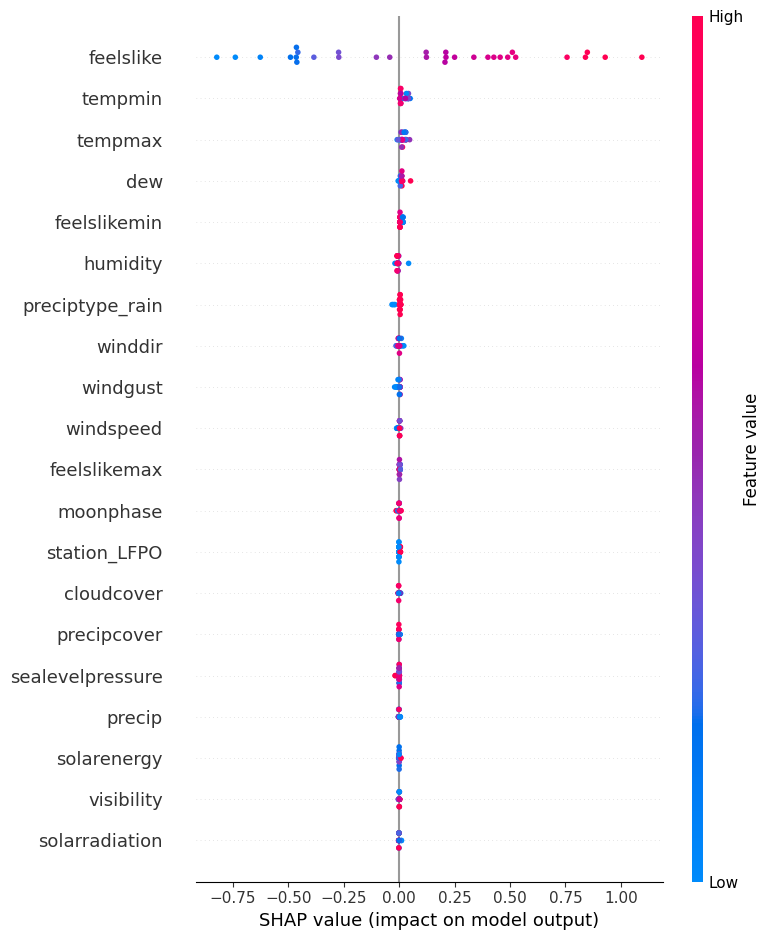

In [ ]:
# Model Interpretability
explainer = shap.Explainer(lgbm_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)




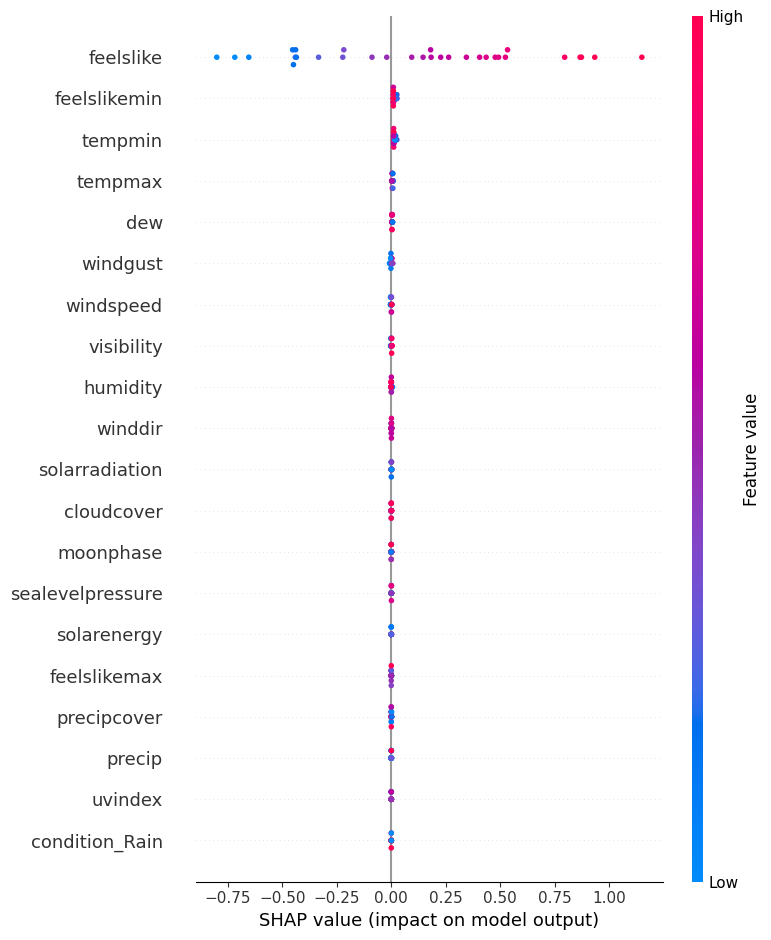

In [ ]:
# Model Interpretability
explainer = shap.Explainer(rf_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)




### 7. Weekly predicting


In [ ]:
file_path = "/content/paris_temperature.csv"

df = pd.read_csv(file_path)


In [ ]:
df['sunrise'] = pd.to_datetime(df['sunrise'])
df['sunset'] = pd.to_datetime(df['sunset'])
df['datetime'] = pd.to_datetime(df['datetime'])

df = df.drop(['name','description','icon'], axis = 1)

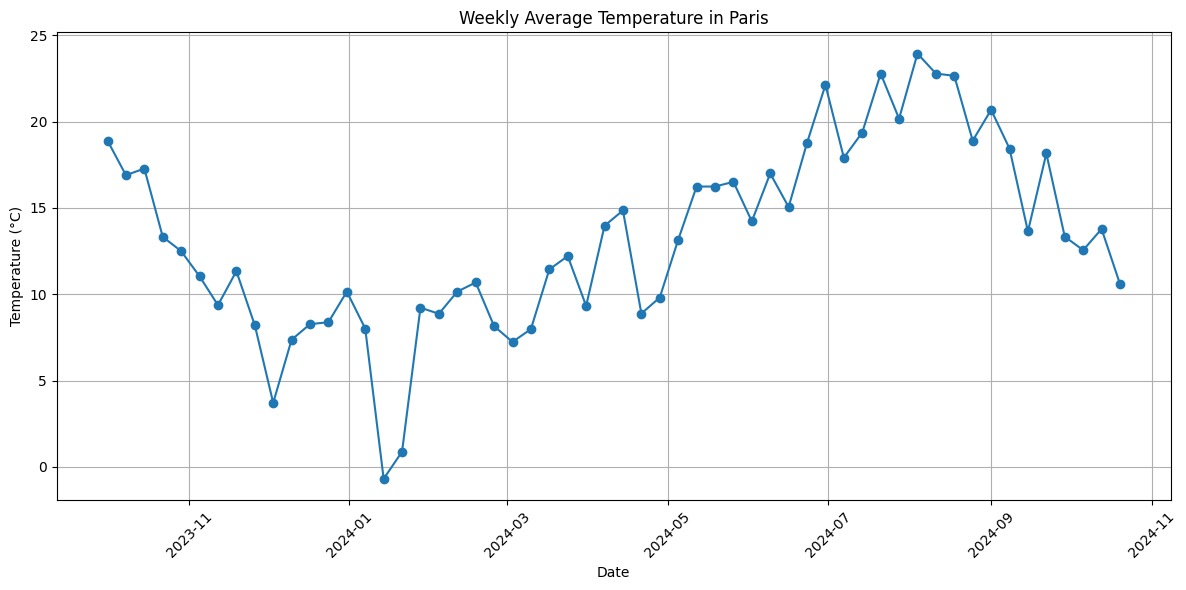

In [ ]:

# Calculate weekly average temperature
weekly_avg = df.set_index('datetime')[['temp']].resample('W').mean()

# Plot weekly average temperature
plt.figure(figsize=(12, 6))
plt.plot(weekly_avg.index, weekly_avg['temp'], marker='o')
plt.title('Weekly Average Temperature in Paris')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [ ]:
# 3. Phân loại đặc trưng
df_numeric = df.select_dtypes(include=[np.number]).columns
df_datetime = df.select_dtypes(include=[np.datetime64]).columns
df_categorical = df.select_dtypes(include=[object]).columns
print(f"Numerical Features: {list(df_numeric)}")
print(f"Categorical Features: {list(df_categorical)}")
print(f"DateTime Features: {list(df_datetime)}")

Numerical Features: ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'moonphase']
Categorical Features: ['preciptype', 'conditions', 'stations']
DateTime Features: ['datetime', 'sunrise', 'sunset']


In [ ]:
df.shape

(382, 30)

In [ ]:
# Xử lý giá trị missing cho cột 'preciptype' và 'stations'
df['preciptype'] = df['preciptype'].fillna('nope')
mode_station = df['stations'].mode()[0]
df['stations'] = df['stations'].fillna(mode_station)


In [ ]:
# Đảm bảo cột 'datetime' có kiểu datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Thêm các feature thời gian: năm, tháng, tuần trong năm, quý, week (tuần trong tháng)
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['weekofyear'] = df['datetime'].dt.isocalendar().week.astype(int)
df['quarter'] = df['datetime'].dt.quarter
df['week'] = df['datetime'].dt.day // 7 + 1  # Xác định tuần trong tháng
df['sunrise_hour'] = df['sunrise'].dt.hour
df['sunrise_minute'] = df['sunrise'].dt.minute
df['sunset_hour'] = df['sunset'].dt.hour
df['sunset_minute'] = df['sunset'].dt.minute

df['daylight_duration'] = (df['sunset_hour'] * 60 + df['sunset_minute']) - \
                          (df['sunrise_hour'] * 60 + df['sunrise_minute'])

# --- 2. Định nghĩa aggregation cho weekly resampling ---

# Sử dụng MEAN cho các feature liên tục:
agg_dict_mean = {
    'tempmax': 'mean',
    'tempmin': 'mean',
    'temp': 'mean',
    'feelslikemax': 'mean',
    'feelslikemin': 'mean',
    'feelslike': 'mean',
    'dew': 'mean',
    'humidity': 'mean',
    'precipprob': 'mean',
    'precipcover': 'mean',
    'windspeed': 'mean',
    'winddir': 'mean',  # Lưu ý: Wind direction có thể cần xử lý đặc biệt, nhưng ta dùng mean cho xu hướng chung.
    'sealevelpressure': 'mean',
    'cloudcover': 'mean',
    'visibility': 'mean',
    'solarradiation': 'mean',
    'uvindex': 'mean',
    'severerisk': 'mean',
    'sunrise_hour': 'mean',
    'sunrise_minute': 'mean',
    'sunset_hour': 'mean',
    'sunset_minute': 'mean',
    'daylight_duration': 'mean'
}

# Sử dụng SUM cho các feature tích lũy:
agg_dict_sum = {
    'precip': 'sum',
    'solarenergy': 'sum',
    'snow': 'sum'
}

# Sử dụng MAX cho các feature cần giá trị cực đại:
agg_dict_max = {
    'snowdepth': 'max',
    'windgust': 'max'
}

# Feature cần mode (giá trị phổ biến nhất)
categorical_cols = ["moonphase"] + df.select_dtypes(include=['object', 'category']).columns.tolist()
agg_dict_mode = {col: lambda x: x.mode()[0] if not x.mode().empty else np.nan for col in set(categorical_cols)}


# Gộp tất cả các dictionary lại
agg_dict_complete = {}
agg_dict_complete.update(agg_dict_mean)
agg_dict_complete.update(agg_dict_sum)
agg_dict_complete.update(agg_dict_max)
agg_dict_complete.update(agg_dict_mode)



# Resample dữ liệu theo tuần sử dụng dictionary aggregation đã định nghĩa
df_weekly = df.resample('W', on='datetime').agg(agg_dict_complete).reset_index()

# Kiểm tra kết q
df_weekly.head()


datetime    tempmax    tempmin       temp  feelslikemax  feelslikemin  \
0 2023-10-01  26.500000  12.500000  18.900000     26.500000     12.500000   
1 2023-10-08  22.828571  11.857143  16.900000     22.857143     11.857143   
2 2023-10-15  22.757143  13.257143  17.285714     22.685714     13.071429   
3 2023-10-22  17.185714  10.600000  13.328571     17.185714      9.985714   
4 2023-10-29  14.857143  10.528571  12.500000     14.857143     10.357143   

   feelslike        dew   humidity  precipprob  ...  daylight_duration  \
0  18.900000  13.700000  74.300000  100.000000  ...         701.000000   
1  16.900000  11.128571  70.814286   71.428571  ...         686.857143   
2  17.200000  10.714286  67.514286   71.428571  ...         661.714286   
3  12.985714   9.557143  78.628571   71.428571  ...         637.571429   
4  12.442857  10.400000  87.400000  100.000000  ...         613.571429   

   precip  solarenergy  snow  snowdepth  windgust  moonphase  \
0   0.144          3.5   0.0        0.0      25.0       0.57   
1   0.427         29.3   0.0        0.0      51.6       0.60   
2   5.259         21.6   0.0        0.0      69.9       0.00   
3  16.082         16.5   0.0        0.0      71.7       0.06   
4  45.606         11.7   0.0        0.0      66.2       0.31   

                                            stations              conditions  \
0  07149099999,07156099999,07146099999,0715709999...  Rain, Partially cloudy   
1  07149099999,07156099999,07146099999,0715709999...  Rain, Partially cloudy   
2  07149099999,07156099999,07146099999,0715709999...  Rain, Partially cloudy   
3  07149099999,07156099999,07146099999,0715709999...          Rain, Overcast   
4  07149099999,07156099999,07146099999,0715709999...          Rain, Overcast   

   preciptype  
0        rain  
1        rain  
2        rain  
3        rain  
4        rain  

[5 rows x 33 columns]

In [ ]:
# Thêm các feature dựa trên dữ liệu lịch sử (lag features) cho 'temp'
df_weekly['temp_lag_1'] = df_weekly['temp'].shift(1)
df_weekly['temp_lag_4'] = df_weekly['temp'].shift(4)

# Thêm feature rolling average: nhiệt độ trung bình của 4 tuần trước (window=4)
df_weekly['temp_roll_4'] = df_weekly['temp'].rolling(window=4, min_periods=1).mean()

# Temperature anomaly (difference from 4-week moving average)
df_weekly['temp_anomaly'] = df_weekly['temp'] - df_weekly['temp'].rolling(window=4, min_periods=1).mean()

# Extreme weather flags
df_weekly['heatwave'] = (df_weekly['temp'] > df_weekly['temp'].quantile(0.95)).astype(int)
df_weekly['cold_spike'] = (df_weekly['temp'] < df_weekly['temp'].quantile(0.05)).astype(int)



# Rolling aggregations theo 4 tuần (28 ngày)
window_size = 4  # 28 ngày ~ 4 tuần

cols_mean_roll = list(agg_dict_mean.keys())
cols_sum_roll = list(agg_dict_sum.keys())
cols_max_roll = list(agg_dict_max.keys())

for col in cols_mean_roll:
    df_weekly[f"{col}_4w_avg"] = df_weekly[col].rolling(window=window_size, min_periods=1).mean()
for col in cols_sum_roll:
    df_weekly[f"{col}_4w_sum"] = df_weekly[col].rolling(window=window_size, min_periods=1).sum()
for col in cols_max_roll:
    df_weekly[f"{col}_4w_max"] = df_weekly[col].rolling(window=window_size, min_periods=1).max()

# Hiển thị kết quả mẫu
df_weekly.head(2)



datetime    tempmax    tempmin  temp  feelslikemax  feelslikemin  \
0 2023-10-01  26.500000  12.500000  18.9     26.500000     12.500000   
1 2023-10-08  22.828571  11.857143  16.9     22.857143     11.857143   

   feelslike        dew   humidity  precipprob  ...  sunrise_hour_4w_avg  \
0       18.9  13.700000  74.300000  100.000000  ...                  7.0   
1       16.9  11.128571  70.814286   71.428571  ...                  7.0   

   sunrise_minute_4w_avg  sunset_hour_4w_avg  sunset_minute_4w_avg  \
0              49.000000                19.0             30.000000   
1              51.928571                19.0             25.857143   

   daylight_duration_4w_avg  precip_4w_sum  solarenergy_4w_sum  snow_4w_sum  \
0                701.000000          0.144                 3.5          0.0   
1                693.928571          0.571                32.8          0.0   

   snowdepth_4w_max  windgust_4w_max  
0               0.0             25.0  
1               0.0             51.6  

[2 rows x 67 columns]

In [ ]:
df_prophet = df_weekly[['datetime', 'temp', 'feelslike', 'solarradiation', 'solarenergy', 'uvindex','humidity']].copy()
df_prophet.rename(columns={'datetime': 'ds', 'temp': 'y'}, inplace=True)
train_prophet = df_prophet[(df_prophet['ds'] >= '2023-10-01') & (df_prophet['ds'] <= '2024-09-15')].copy()
test_prophet = df_prophet[df_prophet['ds'] > '2024-09-15'].copy()

print(f" Train shape: {train_prophet.shape}, Test shape: {test_prophet.shape}")

model = Prophet()
regressors = [ 'feelslike', 'solarradiation', 'solarenergy', 'uvindex','humidity']
for reg in regressors:
    model.add_regressor(reg)
model.fit(train_prophet)

future = test_prophet[['ds', 'feelslike', 'solarradiation', 'solarenergy', 'uvindex','humidity']].copy()
forecast = model.predict(future)


forecast_test = forecast[['ds', 'yhat']]
results = test_prophet[['ds', 'y']].merge(forecast_test, on='ds', how='left')


rmse_prophet = np.sqrt(mean_squared_error(results["y"], results["yhat"]))
r2_prophet = r2_score(results["y"], results["yhat"])

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_prophet = mean_absolute_percentage_error(results["y"], results["yhat"])

print(f"📌 RMSE Prophet: {rmse_prophet:.2f}")
print(f"📌 R² Score Prophet: {r2_prophet:.4f}")
print(f"📌 MAPE Prophet: {mape_prophet:.2f}%")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp83io_333/n20vqmuj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp83io_333/4721izy4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59356', 'data', 'file=/tmp/tmp83io_333/n20vqmuj.json', 'init=/tmp/tmp83io_333/4721izy4.json', 'output', 'file=/tmp/tmp83io_333/prophet_model41kmqu9k/prophet_model-20250330163125.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:31:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Train shape: (51, 7), Test shape: (5, 7)


16:31:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


📌 RMSE Prophet: 0.69
📌 R² Score Prophet: 0.9231
📌 MAPE Prophet: 5.19%


In [ ]:
# 3. Phân loại đặc trưng
df_numeric = df_weekly.select_dtypes(include=[np.number]).columns
df_datetime = df_weekly.select_dtypes(include=[np.datetime64]).columns
df_categorical = df_weekly.select_dtypes(include=[object]).columns
print(f"Numerical Features: {list(df_numeric)}")
print(f"Categorical Features: {list(df_categorical)}")
print(f"DateTime Features: {list(df_datetime)}")

Numerical Features: ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precipprob', 'precipcover', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'uvindex', 'severerisk', 'sunrise_hour', 'sunrise_minute', 'sunset_hour', 'sunset_minute', 'daylight_duration', 'precip', 'solarenergy', 'snow', 'snowdepth', 'windgust', 'moonphase', 'temp_lag_1', 'temp_lag_4', 'temp_roll_4', 'temp_anomaly', 'heatwave', 'cold_spike', 'tempmax_4w_avg', 'tempmin_4w_avg', 'temp_4w_avg', 'feelslikemax_4w_avg', 'feelslikemin_4w_avg', 'feelslike_4w_avg', 'dew_4w_avg', 'humidity_4w_avg', 'precipprob_4w_avg', 'precipcover_4w_avg', 'windspeed_4w_avg', 'winddir_4w_avg', 'sealevelpressure_4w_avg', 'cloudcover_4w_avg', 'visibility_4w_avg', 'solarradiation_4w_avg', 'uvindex_4w_avg', 'severerisk_4w_avg', 'sunrise_hour_4w_avg', 'sunrise_minute_4w_avg', 'sunset_hour_4w_avg', 'sunset_minute_4w_avg', 'daylight_duration_4w_avg', 'precip_4w_s

In [ ]:
# Xử lý giá trị missing cho cột 'preciptype' và 'stations'

df_datetime = df_weekly[df_datetime].copy()

# Lấy dữ liệu numeric gốc
df_numeric = df_weekly[df_numeric].copy()

# One-Hot Encoding cho cột phân loại
mlb_col = ['conditions', 'stations']
df_categorical = df_categorical.drop(mlb_col)
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
df_encoded = pd.DataFrame(
    encoder.fit_transform(df[df_categorical]),
    index=df.index
)
df_encoded.columns = encoder.get_feature_names_out(df_categorical)

# Tạo list từ cột conditions và stations để xử lý MultiLabelBinarizer
df_weekly['conditions_list'] = df_weekly['conditions'].apply(lambda x: [cond.strip() for cond in x.split(',')] if isinstance(x, str) else [])
df_weekly['stations_list'] = df_weekly['stations'].apply(lambda x: [s.strip() for s in x.split(',')] if isinstance(x, str) else [])

from sklearn.preprocessing import MultiLabelBinarizer as MLB
mlb = MLB()

# Mã hóa conditions
conditions_encoded_df = mlb.fit_transform(df['conditions_list'])
df_conditions = pd.DataFrame(conditions_encoded_df, columns=[f'condition_{c}' for c in mlb.classes_], index=df.index)


# Mã hóa stations
stations_encoded_df = mlb.fit_transform(df['stations_list'])
df_stations = pd.DataFrame(stations_encoded_df, columns=[f'station_{s}' for s in mlb.classes_], index=df.index)

# Gộp tất cả các phần đã xử lý vào dataset
df_processed = pd.concat([df_numeric, df_encoded, df_conditions, df_stations, df_datetime], axis=1)

df_processed.head(3)


KeyError: "['conditions_list', 'stations_list'] not in index"

In [ ]:

# Chia tập train/test theo datetime
train_weekly = df_processed[(df_processed['datetime'] >= '2023-10-01') & (df_processed['datetime'] <= '2024-09-15')].copy()
test_weekly = df_processed[df_processed['datetime'] > '2024-09-15'].copy()

# Xác định các cột categorical đã encode
categorical_cols = [col for col in df_processed.columns
                    if col.startswith("preciptype_")
                    or col.startswith("condition_")
                    or col.startswith("station_")]

# Tạo bản sao của DataFrame để scale
train_weekly_scaled = train_weekly.copy()
test_weekly_scaled = test_weekly.copy()

# Xác định các cột cần scale
all_numeric = df_processed.select_dtypes(include=[np.number]).columns.tolist()
time_cols = ['datetime', 'year', 'month', 'weekofyear', 'quarter', 'week',
             'sunrise_hour', 'sunrise_minute', 'sunset_hour', 'sunset_minute', 'daylight_duration']
# Chỉ giữ lại những cột có trong df_processed
time_cols = [col for col in time_cols if col in df_processed.columns]
cols_to_scale = [col for col in all_numeric if col not in categorical_cols and col not in time_cols]

# Khởi tạo StandardScaler
scaler = StandardScaler()
train_weekly_scaled.loc[:, cols_to_scale] = scaler.fit_transform(train_weekly.loc[:, cols_to_scale])
test_weekly_scaled.loc[:, cols_to_scale] = scaler.transform(test_weekly.loc[:, cols_to_scale])

# Kiểm tra kết quả
print(train_weekly_scaled.shape)
print(test_weekly_scaled.shape)





(51, 86)
(5, 86)


In [ ]:
X_train = train_weekly_scaled.drop(columns=['datetime', 'temp'])
X_train.columns = X_train.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
y_train = train_weekly_scaled['temp']
X_test = test_weekly_scaled.drop(columns=['datetime', 'temp'])
X_test.columns = X_test.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
y_test = test_weekly_scaled['temp']

In [ ]:
# Tìm các cột có giá trị NaN trong X_train và X_test
missing_cols_train = X_train.columns[X_train.isna().any()]
missing_cols_test  = X_test.columns[X_test.isna().any()]

print("Các cột có NaN trong X_train:", missing_cols_train)
print("Các cột có NaN trong X_test:", missing_cols_test)

# Hàm xử lý nội suy tuyến tính và điền giá trị trung bình cho cột có NaN
def fill_missing(col):
    return col.interpolate(method='linear').fillna(col.mean())

# Áp dụng cho X_train và X_test
X_train[missing_cols_train] = X_train[missing_cols_train].apply(fill_missing)
X_test[missing_cols_test]   = X_test[missing_cols_test].apply(fill_missing)

Các cột có NaN trong X_train: Index(['temp_lag_1', 'temp_lag_4'], dtype='object')
Các cột có NaN trong X_test: Index([], dtype='object')


In [ ]:
# Tìm các cột có kiểu dữ liệu datetime
datetime_cols = df_processed.select_dtypes(include=['datetime64']).columns.tolist()

# Xóa cột datetime khỏi tập train & test
X_train = X_train.drop(columns=datetime_cols, errors='ignore')
X_test = X_test.drop(columns=datetime_cols, errors='ignore')


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

def objective(trial):
    # Gợi ý các siêu tham số cho mô hình
    params = {
    'num_leaves': trial.suggest_int('num_leaves', 10, 50),        # giảm phạm vi số lá
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),  # giảm phạm vi learning_rate
    'n_estimators': trial.suggest_int('n_estimators', 20, 200)      # giảm số lượng cây
    }


    # Khởi tạo mô hình LightGBM với các tham số được gợi ý
    model = lgb.LGBMRegressor(**params,random_state=42)

    # Sử dụng TimeSeriesSplit cho CV trong dữ liệu time series
    tscv = TimeSeriesSplit(n_splits=2)
    rmse_scores = []  # Danh sách lưu RMSE cho mỗi split

    for train_index, val_index in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        # Tính RMSE cho lần chia này
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    # Trả về trung bình RMSE qua các split
    return np.mean(rmse_scores)


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
best_params = study.best_params
lgbm_model = lgb.LGBMRegressor(**best_params, random_state=42)
lgbm_model.fit(X_train, y_train)
lgbm_pred = lgbm_model.predict(X_test)

[I 2025-03-30 16:30:22,429] A new study created in memory with name: no-name-00df388a-53c4-4688-b39d-f811339705f7
[I 2025-03-30 16:30:22,471] Trial 0 finished with value: 1.0948719900334272 and parameters: {'num_leaves': 36, 'learning_rate': 0.0239342770593622, 'n_estimators': 171}. Best is trial 0 with value: 1.0948719900334272.
[I 2025-03-30 16:30:22,496] Trial 1 finished with value: 1.0948719900334272 and parameters: {'num_leaves': 24, 'learning_rate': 0.09151257690468485, 'n_estimators': 66}. Best is trial 0 with value: 1.0948719900334272.
[I 2025-03-30 16:30:22,517] Trial 2 finished with value: 1.0948719900334272 and parameters: {'num_leaves': 14, 'learning_rate': 0.09327504436449928, 'n_estimators': 25}. Best is trial 0 with value: 1.0948719900334272.
[I 2025-03-30 16:30:22,541] Trial 3 finished with value: 1.0948719900334272 and parameters: {'num_leaves': 34, 'learning_rate': 0.056671981939851304, 'n_estimators': 89}. Best is trial 0 with value: 1.0948719900334272.
[I 2025-03-30

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 17, number of used features: 0
[LightGBM] [Info] Start training from score -0.637156
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

[I 2025-03-30 16:30:22,650] Trial 7 finished with value: 1.0948719900334272 and parameters: {'num_leaves': 27, 'learning_rate': 0.0669361194117515, 'n_estimators': 85}. Best is trial 0 with value: 1.0948719900334272.
[I 2025-03-30 16:30:22,679] Trial 8 finished with value: 1.0948719900334272 and parameters: {'num_leaves': 18, 'learning_rate': 0.020560199506493154, 'n_estimators': 179}. Best is trial 0 with value: 1.0948719900334272.
[I 2025-03-30 16:30:22,705] Trial 9 finished with value: 1.0948719900334272 and parameters: {'num_leaves': 39, 'learning_rate': 0.014853025320899927, 'n_estimators': 110}. Best is trial 0 with value: 1.0948719900334272.
[I 2025-03-30 16:30:22,759] Trial 10 finished with value: 1.0948719900334272 and parameters: {'num_leaves': 48, 'learning_rate': 0.038957143500846676, 'n_estimators': 200}. Best is trial 0 with value: 1.0948719900334272.
[I 2025-03-30 16:30:22,792] Trial 11 finished with value: 1.0948719900334272 and parameters: {'num_leaves': 27, 'learning_

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 17, number of used features: 0
[LightGBM] [Info] Start training from score -0.637156
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

[I 2025-03-30 16:30:22,921] Trial 14 finished with value: 1.0948719900334272 and parameters: {'num_leaves': 10, 'learning_rate': 0.039343873169931085, 'n_estimators': 147}. Best is trial 0 with value: 1.0948719900334272.
[I 2025-03-30 16:30:22,965] Trial 15 finished with value: 1.0948719900334272 and parameters: {'num_leaves': 22, 'learning_rate': 0.08110281356249319, 'n_estimators': 130}. Best is trial 0 with value: 1.0948719900334272.
[I 2025-03-30 16:30:23,009] Trial 16 finished with value: 1.0948719900334272 and parameters: {'num_leaves': 41, 'learning_rate': 0.0540750198037445, 'n_estimators': 182}. Best is trial 0 with value: 1.0948719900334272.
[I 2025-03-30 16:30:23,077] Trial 17 finished with value: 1.0948719900334272 and parameters: {'num_leaves': 49, 'learning_rate': 0.05095393381611557, 'n_estimators': 73}. Best is trial 0 with value: 1.0948719900334272.


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 17, number of used features: 0
[LightGBM] [Info] Start training from score -0.637156
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

[I 2025-03-30 16:30:23,163] Trial 18 finished with value: 1.0948719900334272 and parameters: {'num_leaves': 32, 'learning_rate': 0.010122735007196293, 'n_estimators': 173}. Best is trial 0 with value: 1.0948719900334272.
[I 2025-03-30 16:30:23,220] Trial 19 finished with value: 1.0948719900334272 and parameters: {'num_leaves': 37, 'learning_rate': 0.09981024317096514, 'n_estimators': 42}. Best is trial 0 with value: 1.0948719900334272.


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 17, number of used features: 0
[LightGBM] [Info] Start training from score -0.637156
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

In [ ]:
rmse_lgbm = np.sqrt(mean_squared_error(y_test, lgbm_pred))
r2_lgbm = r2_score(y_test, lgbm_pred)
mape_lgbm = mean_absolute_percentage_error(y_test, lgbm_pred)

print(f"🔥 RMSE-LGBM: {rmse_lgbm}")
print(f"🔥 R² Score-LGBM: {r2_lgbm}")
print(f"🔥 MAPE-LGBM: {mape_lgbm}")

🔥 RMSE-LGBM: 0.2595089953927574
🔥 R² Score-LGBM: 0.6527374904415271
🔥 MAPE-LGBM: 4.572759918124643


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import optuna

def objective(trial):
    # Giới hạn giá trị để giảm overfitting
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),  # Giảm số cây
        'max_depth': trial.suggest_int('max_depth', 5, 15),  # Giới hạn độ sâu
        'min_samples_split': trial.suggest_int('min_samples_split', 5, 20),  # Tránh tách quá sớm
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 3, 15),  # Tránh cây quá nhỏ
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])  # Không dùng "None"
    }

    model = RandomForestRegressor(**params, random_state=42)

    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for train_index, val_index in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

# Tối ưu hóa bằng Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)
best_params = study.best_params

# Huấn luyện mô hình với tham số tốt nhất
rf_model = RandomForestRegressor(**best_params, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Đánh giá hiệu suất
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_pred))
r2_rf = r2_score(y_test, rf_pred)
mape_rf = mean_absolute_percentage_error(y_test, rf_pred)

print(f"🔥 RMSE-RF: {rmse_rf}")
print(f"🔥 R² Score-RF: {r2_rf}")
print(f"🔥 MAPE-RF: {mape_rf}")


[I 2025-03-30 15:34:21,583] A new study created in memory with name: no-name-0002d951-b050-4a83-9fba-859bdca03a84
[I 2025-03-30 15:34:25,009] Trial 0 finished with value: 0.6155015817358696 and parameters: {'n_estimators': 314, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.6155015817358696.
[I 2025-03-30 15:34:30,614] Trial 1 finished with value: 0.8653858743477271 and parameters: {'n_estimators': 484, 'max_depth': 13, 'min_samples_split': 18, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 0 with value: 0.6155015817358696.
[I 2025-03-30 15:34:32,278] Trial 2 finished with value: 0.7855046977371108 and parameters: {'n_estimators': 164, 'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6155015817358696.
[I 2025-03-30 15:34:33,927] Trial 3 finished with value: 0.9872560501834124 and parameters: {'n_estimators': 212, 'max_depth': 15,

🔥 RMSE-RF: 0.13045331921230294
🔥 R² Score-RF: 0.9122467249516187
🔥 MAPE-RF: 3.0787532963672795


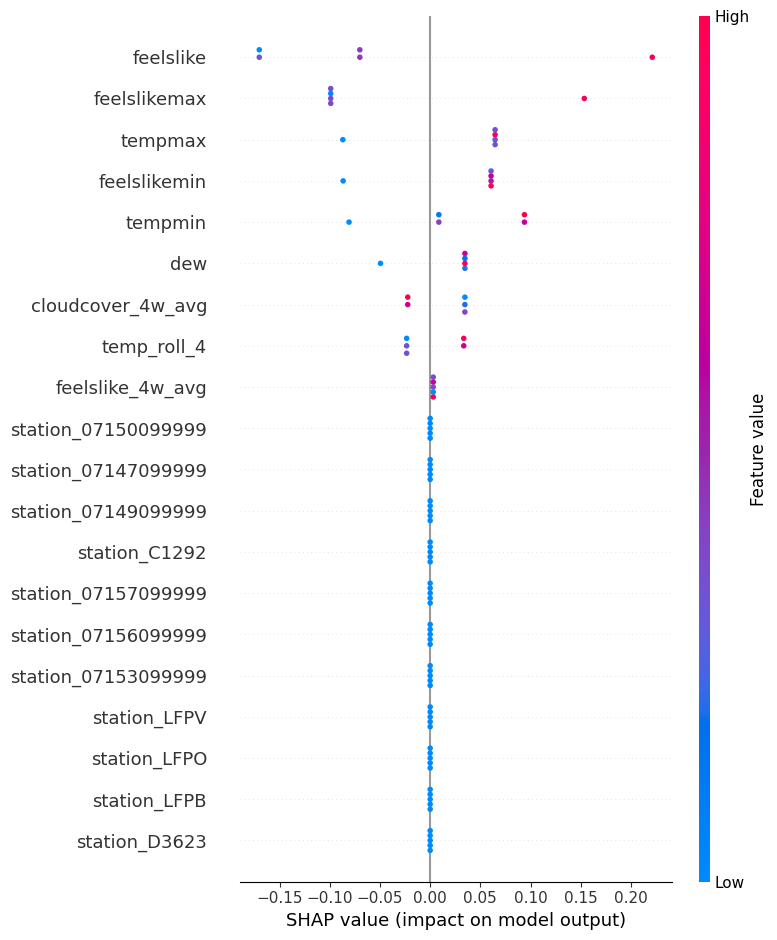

In [ ]:
# Model Interpretability
explainer = shap.Explainer(lgbm_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)




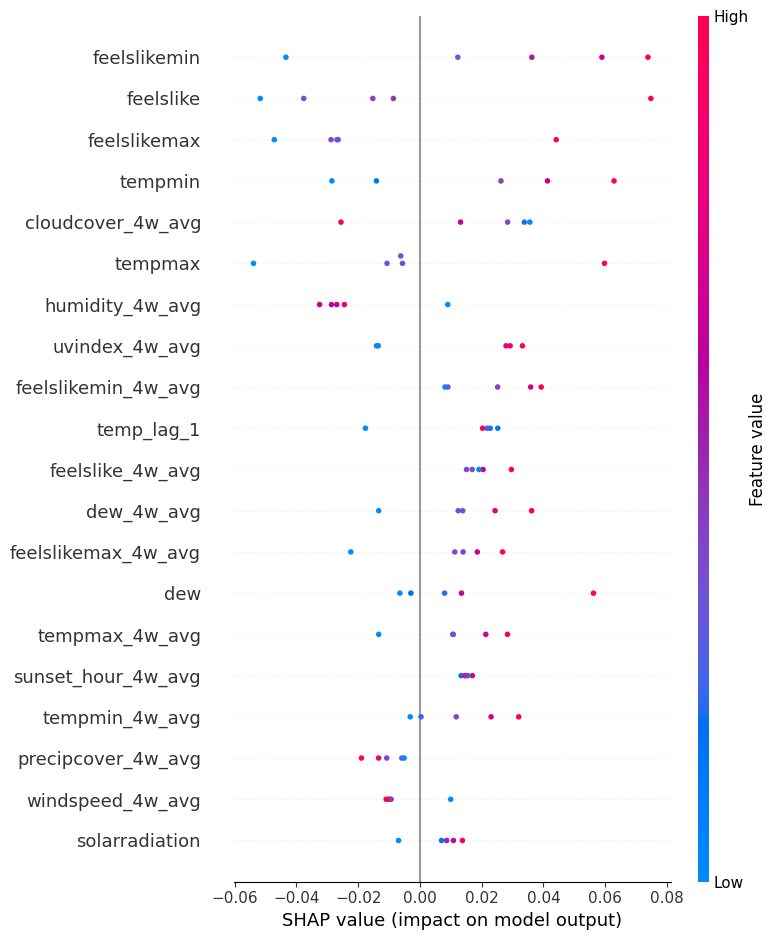

In [ ]:
# 6c. Model Interpretability
explainer = shap.Explainer(rf_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)




In [ ]:
data = {'Model': ['Prophet', 'RF', 'LGBM'],
        'RMSE': [rmse_prophet, rmse_rf, rmse_lgbm],
        'R2': [r2_prophet, r2_rf, r2_lgbm],
        'MAPE': [mape_prophet, mape_rf, mape_lgbm]}
df_metrics = pd.DataFrame(data)
df_metrics


Model      RMSE        R2        MAPE
0  Prophet  0.689760  0.923056    5.191517
1       RF  0.130453  0.912247    3.078753
2     LGBM  0.102272  0.946066  209.972297

**NHẬN XÉT KẾT QUẢ**

1. LGBM (LightGBM)
* RMSE: 0.102272 → thấp nhất, cho thấy sai số bình phương trung bình thấp nhất → dự báo tốt.

* R²: 0.946066 → cao nhất → mô hình giải thích được ~94.6% phương sai của dữ liệu.

* MAPE: 209.97 → rất cao, điều này bất thường và là dấu hiệu cảnh báo. Có thể dữ liệu đầu vào có giá trị thực tế rất nhỏ, khiến MAPE bị thổi phồng, hoặc mô hình dự báo sai nghiêm trọng ở một vài điểm nhỏ.

2. RF (Random Forest)
* RMSE: 0.130453 → thấp, dự báo khá chính xác.
* R²: 0.912247 → cao → mô hình khá tốt.
* MAPE: 3.078753 → thấp hơn Prophet và rất ổn định → mô hình có độ chính xác tốt với sai số tương đối thấp.

3. Prophet
* RMSE: 0.689760 → cao nhất trong 3 mô hình → có chút sai số trong dự báo.
* R²: 0.923056 → khá cao, nhưng không phải cao nhất.
* MAPE: 5.191517 → cao nhất (trừ LGBM bị lỗi), cho thấy độ chính xác cao.